# CAB420, Week 1 Practical - Question 2 Solution
## Linear Regression

Using the dataset from Problem 1, split the data into training, validation and testing as follows:
* Training: All data from the years 2014-2016
* Validation: All data from 2017
* Training: All data from 2018

Develop a regression model to predict one of the cycleway data series in your dataset. In developing this model you should:
* Initially, use all weather data (temperature, rainfall and solar exposure) and all other data series for a particular counter type (i.e. if you’re predicting cyclists inbound for a counter, use all other cyclist inbound counters)
* Use p-values, qqplots, and performance on the validation set to remove terms and improve the model.

When you have finished refining the model, evaluate it on test set, and compare the Root Mean Squared Error (RMSE) for the training, validation and test sets.

In training the model, you will need to ensure that you have no samples (i.e. rows) with missing data. As such, you should remove samples with missing data from the dataset before training and evaluating the model. This may also mean that you have to remove some columns that contain large amounts of missing data.

In [ ]:
# unlike MATLAB, core Python is limited to a few data types and built in methods
# Thats ok though, because there is a tonne of open source packages that do
# pretty much everything we need, we just need to import them

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

Start by loading the data we merged in Q1.

In [ ]:
combined = pd.read_csv('combined(1).csv')
combined['Date']= pd.to_datetime(combined['Date'])
combined.head()

Now find columns/features/covariates that have a suitable amount of data, lets say 300 is the minimum number of samples we need.

In [3]:
threshold = 300
columns_to_remove = []
for column in combined.columns.values:
  if np.sum(combined[column].isna()) > 300:
    # add this column to the list that should be removed
    columns_to_remove.append(column)

print(columns_to_remove)
print(len(columns_to_remove))    
# now lets remove them
combined = combined.drop(columns_to_remove, axis=1)
print(combined.shape)

['North Brisbane Bikeway Mann Park Windsor Cyclists Outbound', 'Jack Pesch Bridge Pedestrians Outbound', 'Kedron Brook Bikeway Lutwyche Pedestrians Outbound', 'Kedron Brook Bikeway Mitchelton Pedestrian Outbound', 'Ekibin Park Pedestrians Outbound', 'Kedron Brook Bikeway Mitchelton', 'Bishop Street Cyclists Inbound', 'Riverwalk Cyclists Inbound', 'Granville Street Bridge Pedestrians Outbound', 'Riverwalk Cyclists Outbound', 'Kedron Brook Bikeway Mitchelton Cyclist Inbound', 'Granville Street Bridge Cyclists Inbound', 'Kedron Brook Bikeway Lutwyche Pedestrians Inbound', 'Ekibin Park Cyclists Inbound', 'Kedron Brook Bikeway Lutwyche Cyclists Inbound', 'Granville Street Bridge Pedestrians Inbound', 'Kedron Brook Bikeway Lutwyche', 'Ekibin Park Cyclists Outbound', 'Ekibin Park Pedestrians Inbound', 'Granville Street Bridge Cyclists Outbound', 'Bishop Street Pedestrians Outbound', 'Riverwalk Pedestrians Inbound', 'Riverwalk Pedestrians Outbound', 'Jack Pesch Bridge Cyclists Inbound', 'Jack 

Now drop any rows that contain a NaN.

In [4]:
print(np.sum(combined.isna(), axis=1))
print(np.sum(np.sum(combined.isna(), axis=1) > 0))
nans = combined.isna()
print(type(nans))
nans.to_csv('nans.csv')

combined_filtered = combined.dropna(axis=0)
# lets have a look at the final data set
print(combined_filtered.head())
print('Final dataset shape = {}'.format(combined_filtered.shape))
print(combined.iloc[11, :])

0       3
1       3
2       3
3       3
4       3
       ..
1821    0
1822    0
1823    0
1824    0
1825    0
Length: 1826, dtype: int64
404
<class 'pandas.core.frame.DataFrame'>
     Unnamed: 0  Rainfall amount (millimetres)       Date  \
169         169                            0.0 2014-06-19   
170         170                            5.8 2014-06-20   
171         171                            0.0 2014-06-21   
172         172                            5.2 2014-06-22   
173         173                            0.2 2014-06-23   

     Maximum temperature (Degree C)  Daily global solar exposure (MJ/m*m)  \
169                            20.3                                   8.0   
170                            22.5                                   9.1   
171                            25.6                                  12.9   
172                            24.2                                  13.0   
173                            24.1                                  

Split into train/test splits.

We'll split the data by time such that pre-2017 is training, 2018 is validation and 2019 is testing.

As a sanity check, we'll print the size of each set when we're finished.

In [5]:
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 276
test train = 258


Now we want to perform linear regression using Ordinary Least Squares. We want to use all weather data from the BOM to start with

In [6]:
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']

We can use any of the counters that we chose. We'll select 'Bicentennial Bikeway Cyclists Inbound' as our response, and use the rest of the inbound counters as our predictors along side thte BOM data.

In [7]:
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'Cyclists Inbound' in x]
# remove the response variable from here
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables = X_bom + X_bcc
Y_variable = 'Bicentennial Bikeway Cyclists Inbound'
Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)

Also create validation and test data.

In [8]:
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)

Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Now create the model and evaluate it

Model 1 RMSE = 623.3791739360704
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     113.1
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          4.59e-118
Time:                        18:13:13   Log-Likelihood:                -6899.6
No. Observations:                 888   AIC:                         1.382e+04
Df Residuals:                     880   BIC:                         1.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.22

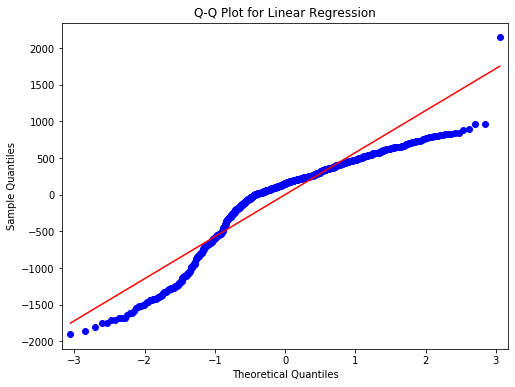

In [9]:
# create the linear model
model = sm.OLS(Y_train, X_train)
# fit the model
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_1_fit.predict(X_val)))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()

Our initial residual plot looks pretty bad. The wonky trend in our residuals suggests that the i.i.d. assumption made when performing ordinary least squares is bad. This implies that the variance is not common within our data samples, meaning that our dataset is heteroskedastic (don't need to worry too much about the implications of this for this class, but the concepts of homoskedasticity and heteroskedasticity are important for successful application of stats/ML models).

Despite this poor model, we will continue on looking to see if we can tidy things up within a OLS model.

Lets see if any variables aren't explicitly correlated with our response variable.

<Figure size 1080x1080 with 0 Axes>

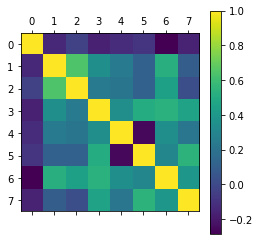

In [10]:
all_variables = X_variables + ['Bicentennial Bikeway Cyclists Inbound']
corr_coeffs = train[all_variables].corr()
plt.figure(figsize=[15, 15])
plt.matshow(corr_coeffs)
plt.colorbar();

In [11]:
print(np.array(corr_coeffs))

[[ 1.         -0.1373654  -0.03216845 -0.16416081 -0.12134364 -0.08392224
  -0.28375855 -0.16317026]
 [-0.1373654   1.          0.64749344  0.35713766  0.24915125  0.1162428
   0.52359272  0.09517715]
 [-0.03216845  0.64749344  1.          0.25038631  0.21496214  0.11422163
   0.44445062  0.02452469]
 [-0.16416081  0.35713766  0.25038631  1.          0.34952993  0.5092007
   0.53424962  0.45741757]
 [-0.12134364  0.24915125  0.21496214  0.34952993  1.         -0.25427468
   0.35673773  0.22037637]
 [-0.08392224  0.1162428   0.11422163  0.5092007  -0.25427468  1.
   0.30354061  0.54449222]
 [-0.28375855  0.52359272  0.44445062  0.53424962  0.35673773  0.30354061
   1.          0.39493691]
 [-0.16317026  0.09517715  0.02452469  0.45741757  0.22037637  0.54449222
   0.39493691  1.        ]]


Looks like there is little evidence in our dataset to identify a linear relationship (correlation) between variables (1 and 2) with our response. So, lets remove them and see what happens.

In [12]:
to_remove = [X_variables[0]]
print('Variables to remove -> {}'.format(to_remove[0]))
train = train.drop(X_variables[0], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)

# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Variables to remove -> Rainfall amount (millimetres)
['Daily global solar exposure (MJ/m*m)', 'Maximum temperature (Degree C)', 'North Brisbane Bikeway Mann Park Windsor Cyclists Inbound', 'Story Bridge West Cyclists Inbound', 'Story Bridge East Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound']


In [13]:
# now make the model and fit it
model_2 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_2_fit = model_2.fit()
pred = model_2_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_2_fit.predict(X_val)))))
print(model_2_fit.summary())
print(model_2_fit.params)

Model 1 RMSE = 622.699754823652
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     131.6
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          8.12e-119
Time:                        18:13:14   Log-Likelihood:                -6900.4
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     881   BIC:                         1.385e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        726.339

x2 still looks ordinary, so we'll remove that as well

In [14]:
to_remove = [X_variables[2]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[2]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Variable to remove -> North Brisbane Bikeway Mann Park Windsor Cyclists Inbound
['Daily global solar exposure (MJ/m*m)', 'Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Story Bridge East Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound']


In [15]:
# now make the model and fit it
model_3 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_3_fit = model_3.fit()
pred = model_3_fit.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_3_fit.predict(X_val)))))
print(model_3_fit.summary())
print(model_3_fit.params)

Model 1 RMSE = 621.548527040436
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     157.9
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          8.66e-120
Time:                        18:13:14   Log-Likelihood:                -6900.7
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     882   BIC:                         1.384e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        716.074

x1 is still looking poor, so we'll remove it too.

In [16]:
to_remove = [X_variables[0]]
print('Variable to remove -> {}'.format(to_remove[0]))
train = train.drop([X_variables[0]], axis=1)
# also want to remove these variable names from the X_variable list
X_variables.remove(to_remove[0])
print(X_variables)
# now lets create a new model and perform regression on that
X_train = np.array(train[X_variables], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train = sm.add_constant(X_train)
# also creating validation and testing data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables], dtype=np.float64)
X_val = sm.add_constant(X_val)
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables], dtype=np.float64)
X_test = sm.add_constant(X_test)

Variable to remove -> Daily global solar exposure (MJ/m*m)
['Maximum temperature (Degree C)', 'Story Bridge West Cyclists Inbound', 'Story Bridge East Cyclists Inbound', 'Schulz Canal Bridge Cyclists Inbound']


In [18]:
# now make the model and fit it
model_4 = sm.OLS(Y_train, X_train)
# fit the model without any regularisation
model_4_fit = model_4.fit()
pred = model_4_fit.predict(X_val)
print('Model 4 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_4_fit.predict(X_val)))))
print(model_4_fit.summary())
print(model_4_fit.params)

Model 4 RMSE = 614.9652599304148
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     196.5
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          1.75e-120
Time:                        18:13:53   Log-Likelihood:                -6901.8
No. Observations:                 888   AIC:                         1.381e+04
Df Residuals:                     883   BIC:                         1.384e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        787.37

Finally, we'll run the model on the test data.

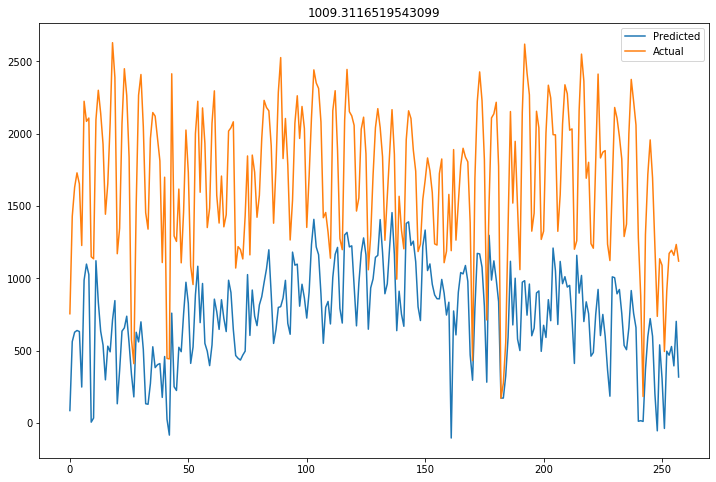

In [20]:
pred = model_4_fit.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, pred))
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(pred)), pred, label='Predicted')
ax.plot(np.arange(len(Y_test)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend()